In [25]:
import pandas as pd
from example.av_discretizer  import AVDiscretizer, Action, Position, Velocity, Rotation
from example.transition import TransitionRecorded
import matplotlib.pyplot as plt
from pathlib import Path
import pgeon.policy_graph as PG
from example.environment import SelfDrivingEnvironment


In [26]:
#path where you stored the copy of the nuScenes dataset.
DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/nuscenes')

#MINI
#nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

#FULL
#nuscenes = NuScenes('v1.0-trainval', dataroot=DATAROOT)

The dataset contains the following columns for each state of the self-driving car:

- instance_token: A unique identifier for the vehicle instance.
- translation: The vehicle's position in 3D space (x, y, z coordinates).
- yaw: The orientation of the vehicle around the vertical axis (rotation angle).
- velocity: The vehicle's speed in a given direction.
- acceleration: The change in velocity over time.
- heading_change_rate: The rate of change of the vehicle's direction.
- timestamp: The time at which the state was recorded.
- scene_token: A unique identifier for the scenario or environment the vehicle is in

Load the CSV data into a DataFrame


In [27]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'heading_change_rate': 'float64',
    'delta_local_x': 'float64',
    'delta_local_y': 'float64'
}
df = pd.read_csv(DATAROOT / 'dataset_from_ego_full.csv', dtype=dtype_dict, parse_dates=['timestamp'])

df.head()

,modality,scene_token,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y
0,lidar,0053e9c440a94c1b84bd9c4223efc4b0,2018-07-27 16:20:30.048445,"[0.2766247744031405, -0.0027369692279543625, 0...",427.968589,1622.155824,0.0,2.581053,0.000018,0.000028,0.000212,0.000000e+00,0.000000
1,lidar,0053e9c440a94c1b84bd9c4223efc4b0,2018-07-27 16:20:30.548859,"[0.27663215946727443, -0.002737971665731827, 0...",427.968593,1622.155822,0.0,2.581038,0.000008,-0.000020,-0.000031,-7.657486e-11,-0.000004
2,lidar,0053e9c440a94c1b84bd9c4223efc4b0,2018-07-27 16:20:31.048731,"[0.27662503731230986, -0.002729398219646146, 0...",427.968591,1622.155823,0.0,2.581052,0.000004,-0.000008,0.000029,7.038325e-10,0.000002
3,lidar,0053e9c440a94c1b84bd9c4223efc4b0,2018-07-27 16:20:31.448537,"[0.2766891809143752, -0.0027446222315419917, 0...",427.968585,1622.155827,0.0,2.580919,0.000018,0.000036,-0.000334,9.009808e-10,0.000007
4,lidar,0053e9c440a94c1b84bd9c4223efc4b0,2018-07-27 16:20:31.948403,"[0.276690691475819, -0.002853827740243303, 0.0...",427.968578,1622.155832,0.0,2.580916,0.000017,-0.000003,-0.000005,-5.687954e-10,0.000009


## Trajectory of AV in a Scene

Let's do an example of computing trajectory of a vehicle in a scene. We then check if the rendering of the scene match the computed trajectory.

In [28]:
# initialize discretizer
av_discretizer = AVDiscretizer()


List of scenes

In [29]:
df['scene_token'].unique()

array(['0053e9c440a94c1b84bd9c4223efc4b0',
       '00590cbfa24a430a8c274b51e1c71231',
       '010fb5bcc7984d0f8f07f99e02366df1',
       '01452fbfbf4543af8acdfd3e8a1ee806',
       '01796494e25c448dadaba70cfcc3532d',
       '019b370afb444a2e8ce85654898307c8',
       '01c3f5e39956402da3e37845632fadca',
       '01c8c59260db4a3682d7b4f8da65425e',
       '01e4fcbe6e49483293ce45727152b36e',
       '0287702725184161af95373198546a59',
       '02e484442a2f411b971edcf96ebbe885',
       '02f1e5e2fc544798aad223f5ae5e8440',
       '034256c9639044f98da7562ef3de3646',
       '034dee1695304630b0692da8c1f153fc',
       '03a8a37d5d444674bae34336e78ac39d',
       '03ee880dd4e348f4b3407f0d073c7c70',
       '04061484361145f5ac6f90a5103b84a6',
       '04219bfdc9004ba2af16d3079ecc4353',
       '04e5f089805540a5a9e73c1b7c54ee8c',
       '055a607b74e04001adef097225a8661a',
       '05d5241d4d5a4c2a9c670dc8c9853c74',
       '06c43bc74aff453081ce83eb126a756e',
       '078e6d7a3d4a429bba404bf12c7a98f2',
       '07a

Select a scene and test the  algorithm


In [30]:
scene_test = df['scene_token'].unique()[1]
example_scene_df = df[df['scene_token']==scene_test]
example_scene_df

,modality,scene_token,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y
38,lidar,00590cbfa24a430a8c274b51e1c71231,2018-08-01 08:39:23.146716,"[0.09485416033489596, 0.010046756429239528, -0...",333.634601,975.784381,0.0,2.951691,1.178886,-0.207124,0.038709,0.000000,0.000000
39,lidar,00590cbfa24a430a8c274b51e1c71231,2018-08-01 08:39:23.647156,"[0.08532914510578349, 0.011252554942682395, -0...",333.090040,975.891821,0.0,2.970841,1.109141,-0.139367,0.038266,0.002716,0.555052
40,lidar,00590cbfa24a430a8c274b51e1c71231,2018-08-01 08:39:24.147583,"[0.07666723910993856, 0.012305012220579333, -0...",332.597577,975.978516,0.0,2.988235,0.999217,-0.219661,0.034759,0.001753,0.500032
41,lidar,00590cbfa24a430a8c274b51e1c71231,2018-08-01 08:39:24.647452,"[0.06851164812512206, 0.012993167594520785, -0...",332.134187,976.048739,0.0,3.004572,0.937609,-0.123249,0.032681,-0.001387,0.468679
42,lidar,00590cbfa24a430a8c274b51e1c71231,2018-08-01 08:39:25.297727,"[0.05981401036805378, 0.01420448319915999, -0....",331.657804,976.113828,0.0,3.022040,0.739392,-0.304819,0.026863,-0.000591,0.480808
43,lidar,00590cbfa24a430a8c274b51e1c71231,2018-08-01 08:39:25.798151,"[0.054054891911171576, 0.01532168154239621, -0...",331.381940,976.149066,0.0,3.033593,0.555741,-0.366992,0.023086,0.002084,0.278098
44,lidar,00590cbfa24a430a8c274b51e1c71231,2018-08-01 08:39:26.298029,"[0.04437875382105022, 0.016583345709911258, -0...",331.074424,976.181782,0.0,3.052963,0.618653,0.125854,0.038750,-0.000622,0.309250
45,lidar,00590cbfa24a430a8c274b51e1c71231,2018-08-01 08:39:26.798517,"[0.023199689665950596, 0.017710329012510448, -...",330.565527,976.220951,0.0,3.095369,1.019809,0.801530,0.084729,-0.006028,0.510366
46,lidar,00590cbfa24a430a8c274b51e1c71231,2018-08-01 08:39:27.198247,"[-0.005863953535157063, 0.018070438721704836, ...",330.001398,976.233025,0.0,-3.129690,1.411598,0.980135,-15.573158,-0.014006,0.564084
47,lidar,00590cbfa24a430a8c274b51e1c71231,2018-08-01 08:39:27.647821,"[-0.048676331038131515, 0.01813951691203388, -...",329.191252,976.197538,0.0,-3.044006,1.803760,0.872295,0.190587,-0.025842,0.810512


Compute the trajectoy of the scene

In [31]:
recorder = TransitionRecorded()
trajectory = av_discretizer.compute_trajectory(example_scene_df)
#recorder.process_and_save_transitions(trajectory, av_discretizer.unique_states)
recorder.process_transitions(trajectory)
#recorder.save_to_csv(av_discretizer.unique_states)

State 0: [0.0, 0.0, 1.178886253993306, 0.0387091266552624, -0.2071240946560785]
Discretized state: 0 (Position(83,243), Velocity(LOW), Rotation(RIGHT))
Action: Action.STRAIGHT

State 1: [0.0027160530840195, 0.5550521085387127, 1.1091414630541712, 0.038265723936874, -0.1393669389719744]
Discretized state: 1 (Position(83,243), Velocity(LOW), Rotation(RIGHT))
Action: Action.BRAKE

State 2: [0.0017527023601842, 0.5000322017658535, 0.999217215546222, 0.034759189344255, -0.2196609046033673]
Discretized state: 2 (Position(83,243), Velocity(LOW), Rotation(RIGHT))
Action: Action.STRAIGHT

State 3: [-0.0013865633260641, 0.468679456485394, 0.9376086685070558, 0.0326813002790633, -0.1232493854173114]
Discretized state: 3 (Position(83,244), Velocity(LOW), Rotation(RIGHT))
Action: Action.BRAKE

State 4: [-0.0005913269133363, 0.4808079853829993, 0.7393923324866699, 0.0268627073927955, -0.3048192472729013]
Discretized state: 4 (Position(82,244), Velocity(LOW), Rotation(RIGHT))
Action: Action.BRAKE

St

Plot trend of state in time for each instance of a scene.

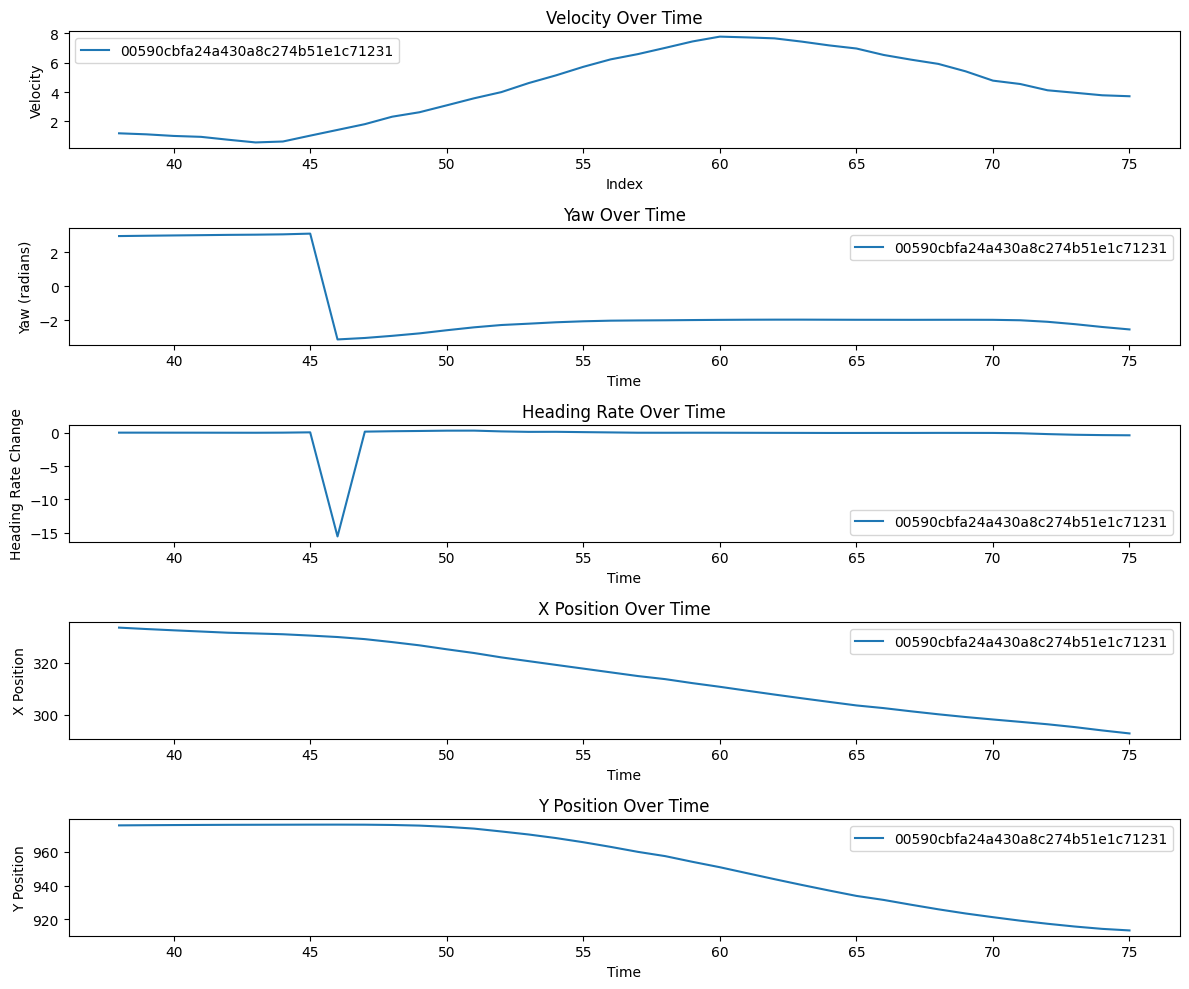

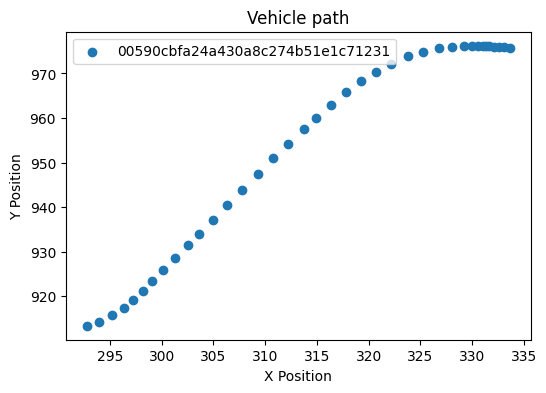

In [32]:
plt.figure(figsize=(12, 10))

plt.subplot(5, 1, 1)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['velocity'], label=scene_token)
plt.title('Velocity Over Time')
plt.xlabel('Index')
plt.ylabel('Velocity')
plt.legend()

plt.subplot(5, 1, 2)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['yaw'], label=scene_token)
plt.title('Yaw Over Time')
plt.xlabel('Time')
plt.ylabel('Yaw (radians)')
plt.legend()

plt.subplot(5, 1, 3)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['heading_change_rate'], label=scene_token)
plt.title('Heading Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Heading Rate Change')
plt.legend()

plt.subplot(5, 1, 4)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['x'], label=scene_token)
plt.title('X Position Over Time')
plt.xlabel('Time')
plt.ylabel('X Position')
plt.legend()

plt.subplot(5, 1, 5)  # Moved inside the same plt.figure block
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['y'], label=scene_token)
plt.title('Y Position Over Time')
plt.xlabel('Time')
plt.ylabel('Y Position')
plt.legend()

plt.tight_layout()
plt.show()


# Plot x vs y positions for each instance
plt.figure(figsize=(6, 4))
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.scatter(group['x'], group['y'], label=scene_token)
plt.title('Vehicle path')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

To render the scene (video):

In [33]:
#nuscenes.render_scene(scene_test)

## All scenes trajectory information


Now, apply the above to all scenes in the dataset.

In [34]:
av_discretizer = AVDiscretizer()
trajectory = av_discretizer.compute_trajectory(df)

State 0: [0.0, 0.0, 1.794926330386777e-05, 0.0002123908612616, 2.83357501223882e-05]
Discretized state: 0 (Position(106,405), Velocity(STOPPED), Rotation(RIGHT))
Action: Action.IDLE

State 1: [-7.657486360657406e-11, -4.001429546259191e-06, 7.996238208746944e-06, -3.075123057995707e-05, -1.9889581616663057e-05]
Discretized state: 1 (Position(106,405), Velocity(STOPPED), Rotation(RIGHT))
Action: Action.IDLE

State 2: [7.038325221624372e-10, 1.9356216942730257e-06, 3.872234936618039e-06, 2.913765921384072e-05, -8.250118574612911e-06]
Discretized state: 2 (Position(106,405), Velocity(STOPPED), Rotation(RIGHT))
Action: Action.IDLE

State 3: [9.009808237637043e-10, 7.375278648924316e-06, 1.8447143624551032e-05, -0.0003340632396596, 3.645495237173277e-05]
Discretized state: 3 (Position(106,405), Velocity(STOPPED), Rotation(RIGHT))
Action: Action.IDLE

State 4: [-5.687954016977859e-10, 8.593950224560533e-06, 1.719250807893226e-05, -5.444324515548071e-06, -2.5099437561641967e-06]
Discretized s

KeyboardInterrupt: 

In [ ]:
transition = TransitionRecorded()

#path_pg_data = Path('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/nuscenes')
transition.process_transitions(trajectory)
transition.save_to_csv(av_discretizer.unique_states, path=str(DATAROOT))

# Policy Graph Generation

In [ ]:
env = SelfDrivingEnvironment()
av_discretizer = AVDiscretizer()
pg = PG.PolicyGraph.from_nodes_and_edges(str(DATAROOT / 'nuscenes_nodes.csv'), str(DATAROOT / 'nuscenes_edges.csv'), env, av_discretizer  )

In [ ]:
print(f'Number of nodes: {len(pg.nodes)}')
print(f'Number of edges: {len(pg.edges)}')

Number of nodes: 229
Number of edges: 276


In [ ]:
arbitrary_state = list(pg.nodes)[10]

print(arbitrary_state)
print(f'  Times visited: {pg.nodes[arbitrary_state]["frequency"]}')
print(f'  p(s):          {pg.nodes[arbitrary_state]["probability"]:.3f}')

(Position(178,451), Velocity(LOW), Rotation(SLIGHT_LEFT))
  Times visited: 1
  p(s):          0.003


In [ ]:
arbitrary_edge = list(pg.edges)[66]

print(f'From:    {arbitrary_edge[0]}')
print(f'Action:  {arbitrary_edge[2]}')
print(f'To:      {arbitrary_edge[1]}')
print(f'  Times visited:      {pg[arbitrary_edge[0]][arbitrary_edge[1]][arbitrary_edge[2]]["frequency"]}')
print(f'  p(s_to,a | s_from): {pg[arbitrary_edge[0]][arbitrary_edge[1]][arbitrary_edge[2]]["probability"]:.3f}')

From:    (Position(456,216), Velocity(MEDIUM), Rotation(FORWARD))
Action:  5
To:      (Position(457,216), Velocity(MEDIUM), Rotation(FORWARD))
  Times visited:      1
  p(s_to,a | s_from): 1.000


### Using PG-based policies

In [ ]:
from pgeon import PGBasedPolicy, PGBasedPolicyMode, PGBasedPolicyNodeNotFoundMode
from random import sample
from pgeon import Predicate


In [ ]:
policy_mode = PGBasedPolicyMode.STOCHASTIC
node_not_found_mode = PGBasedPolicyNodeNotFoundMode.FIND_SIMILAR_NODES

policy = PGBasedPolicy(pg, policy_mode,node_not_found_mode )
pg._normalize()
print(f'Policy Graph with {policy_mode} and {node_not_found_mode}')
print(f'PG number of nodes: {len(policy.pg.nodes)}')
print(f'PG number of edges: {len(policy.pg.edges)}')
        
        
arbitrary_state = [1484, 1180, 5, 3]#sample(policy.pg.nodes,1)[0]
discretized_obs = policy.pg.discretizer.discretize(arbitrary_state)
str_obs = av_discretizer.state_to_str(discretized_obs)
str_to_state = av_discretizer.str_to_state(str_obs)
action = policy.act(arbitrary_state)

        
print(f'Observed state:  {arbitrary_state}')
print(f'Discretization:  {discretized_obs}')
#print(f'time visited: {policy.pg.nodes[discretized_obs]["frequency"]}')
print(f'Selected action: {action}')



Policy Graph with PGBasedPolicyMode.STOCHASTIC and PGBasedPolicyNodeNotFoundMode.FIND_SIMILAR_NODES
PG number of nodes: 229
PG number of edges: 276
(Position(371,295), Velocity(LOW), Rotation(RIGHT))
Observed state:  [1484, 1180, 5, 3]
Discretization:  (Position(371,295), Velocity(LOW), Rotation(RIGHT))
Selected action: (7, False)


Question 1

In [ ]:
possible_actions = pg.question1(discretized_obs, verbose=True)

I will take one of these actions:
	-> STRAIGHT 	Prob: 66.67 %
	-> BRAKE_TURN_LEFT 	Prob: 33.33 %


Question 2

In [ ]:
action_id = AVDiscretizer.get_action_id(Action.IDLE)
best_states = pg.question2(action_id, verbose=True)
                

*********************************
* When do you perform action 1?
*********************************
Most probable in 4 states:
	-> (Position(329,259), Velocity(STOPPED), Rotation(RIGHT))
	-> (Position(330,225), Velocity(LOW), Rotation(LEFT))
	-> (Position(77,167), Velocity(STOPPED), Rotation(RIGHT))
	-> (Position(330,225), Velocity(STOPPED), Rotation(LEFT))


In [ ]:
policy_modes = [PGBasedPolicyMode.STOCHASTIC, PGBasedPolicyMode.GREEDY]
node_not_found_modes = [PGBasedPolicyNodeNotFoundMode.RANDOM_UNIFORM, PGBasedPolicyNodeNotFoundMode.FIND_SIMILAR_NODES]
action_id = AVDiscretizer.get_action_id(Action.GAS_STRAIGHT)


for policy_mode in policy_modes:
    for node_not_found_mode in node_not_found_modes:
        policy = PGBasedPolicy(pg, mode=policy_mode,  node_not_found_mode=node_not_found_mode)
        greedy = True if policy_mode is PGBasedPolicyMode.GREEDY else False
        print(f'Policy Graph with {policy_mode} and {node_not_found_mode}')
        print()
        print(f'Supposing I was in 107,405, stopped and heading right, '
            f'if I did not choose to gas and go straight was due to...')
        policy.pg._normalize() #do i need to normalize before this step?
        counterfactuals = policy.pg.question3((
            Predicate(Position, [177, 449]),
            Predicate(Velocity, [Velocity(Velocity.LOW)]),
            Predicate(Rotation, [Rotation(Rotation.LEFT)])), action_id, greedy, verbose=True)
        
        print()

AttributeError: GAS_STRAIGHT

# Policy Graph Evaluation and Comparison

## Compute Static Metrics


In [ ]:
from example.nuscenes.evaluator import PolicyGraphEvaluator
evaluator = PolicyGraphEvaluator(pg)
entropy_metrics_graph = evaluator.compute_entropy_metrics()

for state, metrics in entropy_metrics_graph.items():
    print(f"State: {state}, H(s): {metrics['Hs']:.2f}, Ha(s): {metrics['Ha']:.2f}, Hw(s): {metrics['Hw']:.2f}")

State: (Position(82,165), Velocity(LOW), Rotation(RIGHT)), H(s): 0.00, Ha(s): 0.00, Hw(s): 0.00
State: (Position(81,165), Velocity(LOW), Rotation(RIGHT)), H(s): 1.00, Ha(s): 0.00, Hw(s): 1.00
State: (Position(80,165), Velocity(LOW), Rotation(RIGHT)), H(s): 1.00, Ha(s): 0.00, Hw(s): 1.00
State: (Position(79,165), Velocity(LOW), Rotation(RIGHT)), H(s): 0.00, Ha(s): 0.00, Hw(s): 0.00
State: (Position(79,166), Velocity(LOW), Rotation(RIGHT)), H(s): 1.00, Ha(s): 0.00, Hw(s): 1.00
State: (Position(78,166), Velocity(LOW), Rotation(RIGHT)), H(s): 0.92, Ha(s): 0.00, Hw(s): 0.92
State: (Position(77,166), Velocity(LOW), Rotation(RIGHT)), H(s): 1.00, Ha(s): 0.00, Hw(s): 1.00
State: (Position(77,167), Velocity(LOW), Rotation(RIGHT)), H(s): 1.17, Ha(s): 0.81, Hw(s): 0.36
State: (Position(77,167), Velocity(STOPPED), Rotation(RIGHT)), H(s): 0.27, Ha(s): 0.00, Hw(s): 0.27
State: (Position(179,451), Velocity(LOW), Rotation(SLIGHT_LEFT)), H(s): 0.00, Ha(s): 0.00, Hw(s): 0.00
State: (Position(178,451), Ve

Ideal situation: knowing the current state unqeuivocally determines the following action and state. To evaluate this we use Entropy.

Entropy Interpretation: level of uncertainty of a variable (check PG_position_paper).

- H_a(s): 0 --> state s perfectly determines the following action a.
Too simple graphs with few nodes show larger action uncertainty, making output less reliable.

- H_w(s): 0 --> state s perfectly determines the following state s'.

- H(s): 0 --> state s perfectly determines the following pais of s', a.

## Improve Policy

In [ ]:
#path_pg_data = Path('/home/saramontese/Desktop/MasterThesis')

#sub_pg = PG.PolicyGraph.from_nodes_and_edges(str(path_pg_data / 'nuscenes_nodes.csv'), str(path_pg_data / 'nuscenes_edges.csv'), env, av_discretizer  )

In [ ]:
#initial_state = example_scene_df.iloc[0][['x', "y", "velocity", "yaw"]].values
#final_state = example_scene_df.iloc[-1][['x', "y", "velocity", "yaw"]].values
#print('initial scene state: ', initial_state)
#print('final scene state: ', final_state)

initial scene state:  [716.0570033520877 1805.9828064891144 4.128817120799394
 -1.6506901524698323]
final scene state:  [650.486841739074 1817.543033825678 3.50612559917745 -2.7694845423521763]


In [ ]:
#sub_agent = PGBasedPolicy(sub_pg, mode=PGBasedPolicyMode.GREEDY)
#reward = env.compute_total_reward(sub_agent, initial_state, final_state, max_steps=100)
#print('scene reward before improvement: ', reward)

In [ ]:
#reward = env.compute_total_reward(pg)
#print('Total PG reward before improvement: ', reward)

Total PG reward before improvement:  None


In [ ]:
#pg.policy_iteration(sub_pg)
#print('scene reward after improvement: ', env.compute_total_reward(pg))


## Compute Rewards

1. I consider the total pg.
2. I consider each scene as episode, with a initial state and end state
3. For each scene, i compute the reward of the PG.
4. I compute the avg scene reward.

I do this for all the possible pgBased policies.

in which format the scenes?
can i create a function that creates a pg from a dataframe without having to store it the dataframe as csv and then load it?

In [ ]:
#for each scenes:
    #initial_state = example_scene_df.iloc[0][['x', "y", "velocity", "yaw"]].values
    #final_state = example_scene_df.iloc[-1][['x', "y", "velocity", "yaw"]].values
    #print('initial scene state: ', initial_state)
    #print('final scene state: ', final_state)